## LIBRARY

In [1]:
import os
import re
import pandas as pd
import tkinter as tk
from tkinter import ttk
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
import matplotlib.pyplot as plt
import networkx as nx
from collections import defaultdict
import math
from collections import Counter
import mplcursors
import matplotlib as mpl
import textwrap

## READING FHIR

In [8]:

directory = 'C:/Users/begon/synthea/output/deneme1'

pattern = re.compile(r'(\"resourceType\": \"(Patient|Encounter|Condition|Observation|Procedure|Medication)\")')

classes = ['Patient', 'Encounter', 'Condition', 'Observation', 'Procedure', 'Medication']

current_resource_type = None
new_resource_type = None
resource_type = None
current_id = None
new_id = None
current_references = []
current_codes = []
display = []
current_patient_id = None
previous_display = None 
previous_code = None 
code_starts_with_LA = False  # Flag to track if the current code starts with "LA"


data = {'ResourceType': [], 'ID': [], 'References': [], 'Codes': [], 'PatientID': []}

counts = {resource_type: 1 for resource_type in classes}

INIT = False

for filename in os.listdir(directory):
    if filename.endswith('.json'):
        with open(os.path.join(directory, filename), 'r', encoding='utf-8') as f:
            for line in f:
                match = pattern.search(line)
                if '"resourceType": "' in line and not match:
                    resource_type = line.split('"')[3]
                    INIT = False
                if match:
                    if match.group(2) in classes:
                        new_resource_type = match.group(2)
                        INIT = True
                        next_line = next(f, None)
                        if next_line and '"id": "' in next_line:
                            new_id = next_line.split('"id": "')[1].split('"')[0]
                if current_resource_type == new_resource_type and '"reference": "urn:uuid:' in line and INIT:
                    reference = line.split(':')[3].split('"')[0]
                    current_references.append(reference)    
                    
                if current_resource_type == new_resource_type and '"code": "' in line and INIT:
                    code = line.split('"code": "')[1].split('"')[0]
                    if any(char.isdigit() for char in code):
                        #print(current_patient_id, code)
                        next_line = next(f, None)
                        if next_line and '"display": "' in next_line:
                            if code.startswith("LA") and previous_display is not None:                    
                                display = previous_display + ': ' + next_line.split('"display": "')[1].split('"')[0]
                                code = previous_code
                                current_codes[-1] = (previous_code, display)
                                #current_codes.append((previous_code, display))
                                #print('(code, display)', (current_patient_id, code, display))
                                code_starts_with_LA = True
                            else:
                                display = next_line.split('"display": "')[1].split('"')[0]
                                current_codes.append((code, display))
                                code_starts_with_LA = False
                                #print('(code, display)', (current_patient_id, code, display))
                        # Update previous display only if the code doesn't start withp "LA"
                        if not code_starts_with_LA:
                            previous_display = display
                            previous_code = code

                 
                if current_resource_type != new_resource_type  and INIT:
                    if current_resource_type and current_id:
                        data['ResourceType'].append(current_resource_type)
                        data['ID'].append(current_id)
                        if current_resource_type == 'Patient':
                            current_patient_id = current_id
                        data['References'].append(tuple(current_references))
                        data['Codes'].append(tuple(current_codes))
                        data['PatientID'].append(current_patient_id)
                        current_references = []
                        current_codes = []
                    current_resource_type = new_resource_type    
                    current_id = new_id

df = pd.DataFrame(data)
grouped = df.groupby('PatientID')
aggregated_data = grouped.sum()
aggregated_data.to_csv('C:/Users/begon/Desktop/LMI PROJECT/GIT-LMI/Patient1.csv')


## DROP DOWN LIST

In [9]:
import pandas as pd

# Assuming df is your DataFrame
# Flatten the 'Codes' column
flattened_df = df.explode('Codes')

# Reset the index after exploding
flattened_df.reset_index(drop=True, inplace=True)

# Assuming flattened_df is your DataFrame after exploding the 'Codes' column

# Extract only the first item of each tuple in the 'Codes' column using list comprehension
options = set(code[0] for code in flattened_df['Codes'])


# Convert the set to a list if needed
options = list(options)

# Print the resulting list of options
print(options)




['8331-1', '78275009', '414545008', '225338004', '2744-1', '99999-1', '1871000124103', '749196', '33367005', '428211000124100', '449381000124108', '99999-10', '171207006', '84100007', '29303009', '224299000', '224355006', '183495009', '201834006', '60027007', '18262-6', '542347', '167291007', '449868002', '713-8', '112790001', '807283', '93031-3', '16114001', '414088005', '132281000119108', '48065-7', '274474001', '33728-7', '223470000', '44608003', '99999-3', '311791003', '2085-9', '2106-3', '29554-3', '439708006', '223495004', '770349000', '269911007', '80382-5', '2498-4', '61746007', '37849005', '33737001', '91146-1', '268425006', '87433001', '6299-2', '104435004', '85548006', '306316000', '371254008', '2571-8', '203082005', '789-8', '93028-9', '385781007', '2708-6', '65363002', '46706006', '840539006', '88805009', '169690007', '762998009', '93761005', '2703-7', '312617', '75893-8', '75325-1', '2160-0', '1121000119107', '284549007', '3173-2', '76437-3', '5794-3', '1796676', '5276500

## OPTIONS BOTH CODE AND DISPLAY

In [10]:
import pandas as pd

flattened_df = df.explode('Codes')
flattened_df.reset_index(drop=True, inplace=True)
#codes = [code[0] for code in flattened_df['Codes']]
#displays = [display[1] for display in flattened_df['Codes']]
# Extract only the first item of each tuple in the 'Codes' column using list comprehension
codes = [code[0] for code in flattened_df['Codes']]

# Extract the second item (display) of each tuple in the 'Codes' column using list comprehension
displays = [display[1] for display in flattened_df['Codes']]

# Combine codes and displays into a single list of options
options_zip = {code: display for code, display in zip(codes, displays)}
options_zip


{'2106-3': 'White',
 '2186-5': 'Not Hispanic or Latino',
 '410620009': 'Well child visit (procedure)',
 '314529007': 'Medication review due (situation)',
 '8302-2': 'Body Height',
 '72514-3': 'Pain severity - 0-10 verbal numeric rating [Score] - Reported',
 '29463-7': 'Body Weight',
 '39156-5': 'Body mass index (BMI) [Ratio]',
 '59576-9': 'Body mass index (BMI) [Percentile] Per age and sex',
 '85354-9': 'Blood pressure panel with all children optional',
 '8462-4': 'Diastolic Blood Pressure',
 '8480-6': 'Systolic Blood Pressure',
 '8867-4': 'Heart rate',
 '9279-1': 'Respiratory rate',
 '6690-2': 'Leukocytes [#/volume] in Blood by Automated count',
 '789-8': 'Erythrocytes [#/volume] in Blood by Automated count',
 '718-7': 'Hemoglobin [Mass/volume] in Blood',
 '4544-3': 'Hematocrit [Volume Fraction] of Blood by Automated count',
 '787-2': 'MCV [Entitic volume] by Automated count',
 '785-6': 'MCH [Entitic mass] by Automated count',
 '786-4': 'MCHC [Mass/volume] by Automated count',
 '21000

## A B C D TEST (ignore this part)

In [ ]:
import random

# Predefined groups made up of letters including at least one of A, B, or C
groups = []
for _ in range(10):  # Generate # groups
    group_size = random.randint(1, 3)  # Random group size between 1 and 10
    group = random.sample(['A', 'B', 'C','D'], group_size) #, 'D', 'E', 'F', 'G', 'H', 'I', 'J'
    groups.append(group)

print(groups)  # Print the generated groups

# Get all unique items from the groups
options = list(set(item for group in groups for item in group))

print(options)  # Print the set of all items


## GROUPS

In [11]:
C= df['Codes'].apply(lambda x: tuple(code[0] for code in x))
groups = [[item] if isinstance(item, int) else list(item) for item in C] # for codes

D= df['Codes'].apply(lambda x: tuple(code[1] for code in x))
groups_display = [[item] if isinstance(item, int) else list(item) for item in D] # for displays

## LOGVIEWER 2 + KEYBOARD ARROWS + COLORED SELECTED NODE

95


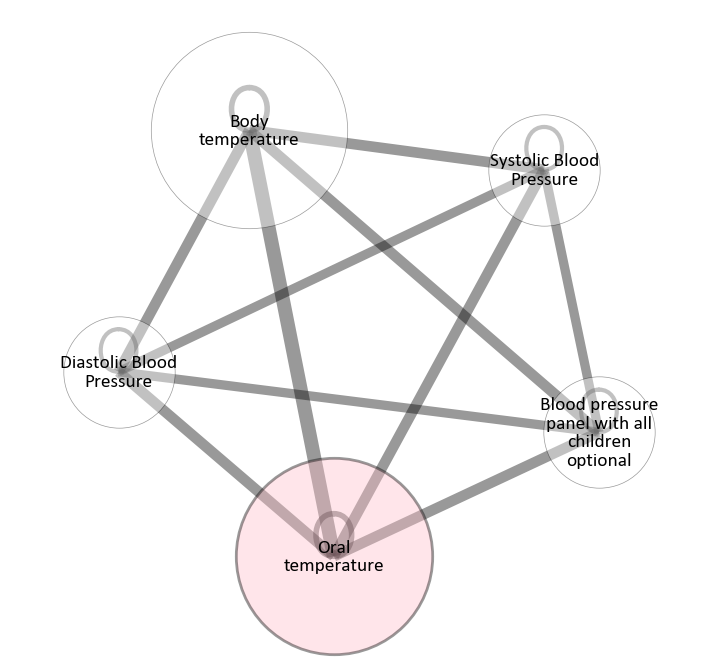

In [12]:
# Define a global variable to store the selected node
selected_node = []
PADDING = 0.1

def on_dropdown_select(event):
    global selected_groups, selected_nodes, selected_code, initial_num_nodes, selected_node
    selected_nodes = []
    selected_code = dropdown.get()  # Get the currently selected item from the dropdown menu
    selected_groups = [group for group in groups if selected_code in group]
    initial_num_nodes = len(set([item for sublist in selected_groups for item in sublist]))
    print(initial_num_nodes)  # Verify initial_num_nodes value

    selected_node = selected_code  # Store the selected node

    # Update slider range and tickinterval
    slider.config(from_=0, to=initial_num_nodes, tickinterval=max(1, initial_num_nodes))

    # Clear log text before inserting new content
    log_text.delete(1.0, tk.END)

    # Insert selected nodes and their translation
    if selected_nodes:
        log_text.insert(tk.END, "Visualized nodes and their translation:\n")
        for node in selected_nodes[::-1]:
            display_name = options_zip.get(node, "Unknown")
            log_text.insert(tk.END, "{}: {}\n".format(node, display_name))

    num_nodes_to_visualize = len(selected_nodes)
    generate_graph(canvas, selected_groups, num_nodes_to_visualize, log_text, selected_node)

    # Update the label with the display value of the selected node
    selected_display = options_zip.get(selected_code, "Unknown")
    display_label.config(text=" {}".format(selected_display))


def on_slider_move(value):
    global selected_groups, selected_nodes, selected_code, selected_node

    num_nodes_to_visualize = int(value)

    selected_groups = [group for group in groups if selected_code in group]

    # Flatten the selected groups and sort them by occurrence count
    all_selected_nodes = [node for group in selected_groups for node in group]
    node_counts = Counter(all_selected_nodes)
    sorted_nodes = sorted(node_counts, key=node_counts.get, reverse=True)

    # Select the nodes to visualize based on the slider value
    selected_nodes = sorted_nodes[:num_nodes_to_visualize]

    # Generate the graph with the selected nodes
    generate_graph(canvas, selected_groups, num_nodes_to_visualize, log_text, selected_node)


def generate_graph(canvas, selected_groups, num_nodes_to_visualize, log_text, selected_node):

    plt.clf()  # Clear current figure
    log_text.delete(1.0, tk.END)  # Clear previous logs
    

    labels = {}  

    G = nx.Graph()  # Initialize empty undirected graph
    
    # Add edges within selected groups
    for group in selected_groups:
        add_edges_within_group(G, group)
        
#     if log_text:
#         log_text.insert(tk.END, "Selected groups: {}\n".format(selected_groups))

    node_counts = Counter([node for group in selected_groups for node in group])

    sorted_nodes = sorted(node_counts, key=node_counts.get, reverse=True)
    
    selected_nodes = sorted_nodes[:num_nodes_to_visualize]
    
    subgraph = G.subgraph(selected_nodes)
    # Configure visual properties
    if len(subgraph) < 11:
        pos = nx.spring_layout(subgraph)
    else:
        pos = nx.circular_layout(subgraph)
    
    # Count occurrences of edges between nodes in selected groups
    edge_occurrences = Counter()
    edge_labels = {}
    for group in selected_groups:
        for i in range(len(group)):
            for j in range(i + 1, len(group)):
                node_pair = tuple(sorted([group[i], group[j]]))
                if node_pair not in edge_occurrences:
                    edge_occurrences[node_pair] = 0
                    edge_labels[node_pair] = f"{group[i]}-{group[j]}"
                edge_occurrences[node_pair] += 1
    
    # Calculate edge widths proportional to occurrences
    edge_widths = [edge_occurrences[tuple(sorted(edge))] for edge in subgraph.edges()]
    
    if log_text and selected_nodes:  # Check if selected_nodes is not empty
        log_text.insert(tk.END, "Visualized nodes and their translation:\n")
        for node in selected_nodes[::-1]:  # Print in reverse order
            display_name = options_zip.get(node, "Unknown")
            log_text.insert(tk.END, "{}: {}\n".format(node, display_name))
    # Print edge widths alongside corresponding node pairs
    for edge, width in zip(subgraph.edges(), edge_widths):
        node_pair = tuple(sorted(edge))
        if log_text:
            log_text.insert(tk.END, f"Edge {edge_labels[node_pair]}: {width}\n")
    
    if log_text:
        log_text.insert(tk.END, "Node occurrences: {}\n".format(node_counts))
      
   # Calculate normalization factors based on the number of nodes to visualize
    num_nodes_to_visualize = max(1, min(num_nodes_to_visualize, len(subgraph.nodes())))
    num_edges = len(subgraph.edges())
    
    if num_nodes_to_visualize > 0:
        # Calculate node size and edge width factors to fit within the desired range
        max_node_size = 20000
        min_node_size = 0
        max_edge_width = 10
        min_edge_width = 0
        
        # Calculate scaling factors if node_counts and edge_occurrences are not empty
        if node_counts:
            node_size_factor = (max_node_size - min_node_size) / max(node_counts.values())
        else:
            node_size_factor = 0
        
        if edge_occurrences:
            edge_width_factor = (max_edge_width - min_edge_width) / max(edge_occurrences.values())
        else:
            edge_width_factor = 0
    
    # Normalize node size and edge width
    node_size = [min(max(node_counts[n] * node_size_factor, min_node_size), max_node_size) for n in subgraph.nodes()]
    edge_widths = [min(max(edge_occurrences[tuple(sorted(edge))] * edge_width_factor, min_edge_width), max_edge_width) for edge in subgraph.edges()]

  
    selected_node_color = "pink"  # Choose a color for the selected node
    selected_node_linewidth = 2.0  # Choose a linewidth for the selected node

    for node in subgraph.nodes():
        if node == selected_node:  # Check if the current node is the selected node
            nx.draw_networkx_nodes(subgraph, pos, nodelist=[node], node_size=node_size_factor * node_counts[node],
                                   node_color=selected_node_color, edgecolors="k", alpha=0.4, linewidths=selected_node_linewidth)
        else:
            nx.draw_networkx_nodes(subgraph, pos, nodelist=[node], node_size=node_size_factor * node_counts[node],
                                   node_color="w", edgecolors="k", alpha=0.4, linewidths=0.5)

    if len(subgraph) > 1:
        nx.draw_networkx_edges(subgraph, pos, width=edge_widths, edge_color="black", alpha=0.4)
    
    # Draw labels on the nodes using plt.annotate
    for node, (x, y) in pos.items():
        text = labels.get(node, "")
        plt.annotate(text, (x, y), fontsize=30, ha='center', va='center')

    # Add padding to the boundaries of the figure
    xmin, xmax = plt.xlim()
    ymin, ymax = plt.ylim()
    xmargin = (xmax - xmin) * PADDING
    ymargin = (ymax - ymin) * PADDING
    plt.xlim(xmin - xmargin, xmax + xmargin)
    plt.ylim(ymin - ymargin, ymax + ymargin)
    
        # Create labels with display names and wrap text
    labels = {}
    for node in subgraph.nodes():
        if node in options_zip:
            label = options_zip[node]
            wrapped_label = '\n'.join(textwrap.wrap(label, width=15))  # Adjust width as needed
            labels[node] = wrapped_label
    
    # Draw labels on the nodes
    nx.draw_networkx_labels(subgraph, pos, labels=labels, font_size=12/math.log(num_nodes_to_visualize+1, 8),
                            font_family='Calibri', font_weight='normal')
    
     

    plt.axis("off")
    canvas.draw()


def add_edges_within_group(G, group):
    if isinstance(group, int):
        return
    for i, u in enumerate(group):
        for v in group[:i]:
            if isinstance(u, str) and isinstance(v, str):
                G.add_edge(u, v, weight=1)
            elif isinstance(u, tuple) and isinstance(v, tuple):
                for a in u:
                    for b in v:
                        G.add_edge(a, b, weight=1)

def on_arrow_key(event):
    global slider
    current_value = int(slider.get())
    if event.keysym == 'Right':
        slider.set(current_value + 1)
    elif event.keysym == 'Left':
        slider.set(current_value - 1)
        


# Create the main Tkinter window
root = tk.Tk()
root.title("Graph Visualization")

# Define the selected groups and dropdown menu
selected_groups = []
dropdown = ttk.Combobox(root, values=options)
dropdown.grid(row=0, column=0, padx=10, pady=10)
dropdown.bind("<<ComboboxSelected>>", on_dropdown_select)

# Define a label to display the value of the selected node
display_label = tk.Label(root, text="")
display_label.grid(row=0, column=1, padx=10, pady=10)

# Define the slider for selecting the number of nodes to visualize
initial_num_nodes = 0
slider = tk.Scale(root, from_=0, to=initial_num_nodes, orient=tk.HORIZONTAL, length=200, tickinterval=initial_num_nodes,
                  command=on_slider_move)  # Remove lambda and extra argument

slider.grid(row=0, column=2, padx=10, pady=10)


# Bind arrow keys to the function
root.bind('<Right>', on_arrow_key)
root.bind('<Left>', on_arrow_key)

# Create the figure and canvas for displaying the graph
fig = plt.figure(figsize=(9, 9))
canvas = FigureCanvasTkAgg(fig, master=root)
canvas.get_tk_widget().grid(row=1, column=0, padx=10, pady=10, columnspan=3)

# Create the log viewer Text widget
log_text = tk.Text(root, wrap=tk.WORD, width=40, height=20)
log_text.grid(row=1, column=3, padx=10, pady=10, sticky="nsew", columnspan=3)

# Configure grid weights to make the log viewer resizable
root.grid_rowconfigure(1, weight=1)
root.grid_columnconfigure(0, weight=1)
root.grid_columnconfigure(1, weight=1)
root.grid_columnconfigure(2, weight=1)

# Generate the initial graph with empty selected groups
generate_graph(canvas, [], 0, log_text, selected_node)

# Start the Tkinter event loop
root.mainloop()

## WRAP TEXT

In [ ]:


def generate_graph(canvas, selected_groups, num_nodes_to_visualize, padding=0.1):
    plt.clf()  # Clear current figure
 
    G = nx.Graph()  # Initialize empty undirected graph
    
    # Add edges within selected groups
    for group in selected_groups:
        add_edges_within_group(G, group)
    
    # Count occurrences of each node in selected groups
    node_counts = Counter([node for group in selected_groups for node in group])
    
    sorted_nodes = sorted(node_counts, key=node_counts.get, reverse=True)
    
    selected_nodes = sorted_nodes[:num_nodes_to_visualize]
    subgraph = G.subgraph(selected_nodes)
    
    # Configure visual properties
    if len(subgraph) < 10:
        pos = nx.spring_layout(subgraph)
    else:
        pos = nx.circular_layout(subgraph)
    
    # Count occurrences of edges between nodes in selected groups
    edge_occurrences = Counter()
    edge_labels = {}
    for group in selected_groups:
        for i in range(len(group)):
            for j in range(i + 1, len(group)):
                node_pair = tuple(sorted([group[i], group[j]]))
                if node_pair not in edge_occurrences:
                    edge_occurrences[node_pair] = 0
                    edge_labels[node_pair] = f"{group[i]}-{group[j]}"
                edge_occurrences[node_pair] += 1
    
    # Calculate edge widths proportional to occurrences
    edge_widths = [edge_occurrences[tuple(sorted(edge))] for edge in subgraph.edges()]
    
    # Calculate normalization factors based on the number of nodes to visualize
    num_nodes_to_visualize = max(1, min(num_nodes_to_visualize, len(subgraph.nodes())))
    num_edges = len(subgraph.edges())
    
    if num_nodes_to_visualize > 0:
        node_size_factor = 5000 / num_nodes_to_visualize
    
    if num_edges > 0:
        edge_width_factor = 1 / num_edges
    
    # Normalize node size and edge width
    node_size = [node_counts[n] * node_size_factor for n in subgraph.nodes()]
    edge_widths = [edge_occurrences[tuple(sorted(edge))] * edge_width_factor for edge in subgraph.edges()]
    
    # Draw nodes and edges with normalized sizes
    nx.draw_networkx_nodes(subgraph, pos, node_size=node_size, node_color="w", edgecolors="k", linewidths=0.5)
    if len(subgraph) > 1:
        nx.draw_networkx_edges(subgraph, pos, width=edge_widths, edge_color="black", alpha=0.4)
    
    # Add padding to the boundaries of the figure
    xmin, xmax = plt.xlim()
    ymin, ymax = plt.ylim()
    xmargin = (xmax - xmin) * padding
    ymargin = (ymax - ymin) * padding
    plt.xlim(xmin - xmargin, xmax + xmargin)
    plt.ylim(ymin - ymargin, ymax + ymargin)
    
    # Create labels with display names and wrap text
    labels = {}
    for node in subgraph.nodes():
        if node in options_zip:
            label = options_zip[node]
            wrapped_label = '\n'.join(textwrap.wrap(label, width=10))  # Adjust width as needed
            labels[node] = wrapped_label
    
    # Draw labels on the nodes
    nx.draw_networkx_labels(subgraph, pos, labels=labels, font_size=20/math.log(num_nodes_to_visualize+1, 3),
                            font_family='Calibri', font_weight='normal')
    
    # Add tooltips to nodes
    cursor = mplcursors.cursor(hover=True)
    cursor.connect("add", lambda sel: sel.annotation.set_text(options_zip.get(sel.target, "")))
    
    # Add hover effect to nodes
    hover_font_size = 30
    for node, (x, y) in pos.items():
        text = labels.get(node, "")
        plt.text(x, y, text, fontsize=hover_font_size, ha='center', va='center', alpha=0.0)
        plt.text(x, y, text, fontsize=hover_font_size, ha='center', va='center', alpha=0.0, zorder=10)
    
    plt.axis("off")
    canvas.draw()



    
def on_dropdown_select(event):
    
    global selected_groups
    
    selected_code = dropdown.get()
    
    selected_groups = [group for group in groups if selected_code in group]
    print('selected_groups', selected_groups)
    
    num_nodes_to_visualize = len(set([item for sublist in selected_groups for item in sublist]))
    print('num_nodes_to_visualize', num_nodes_to_visualize)
    slider.config(from_=1, to=num_nodes_to_visualize, tickinterval=num_nodes_to_visualize-1)
    
    generate_graph(canvas, selected_groups, 1)

def add_edges_within_group(G, group):
    if isinstance(group, int):
        return
    for i, u in enumerate(group):
        for v in group[:i]:
            if isinstance(u, str) and isinstance(v, str):
                G.add_edge(u, v, weight=1)
            elif isinstance(u, tuple) and isinstance(v, tuple):
                for a in u:
                    for b in v:
                        G.add_edge(a, b, weight=1)

root = tk.Tk()
root.title("Graph Visualization")

selected_groups = []
dropdown = ttk.Combobox(root, values=options)
dropdown.grid(row=0, column=0, padx=10, pady=10)
dropdown.bind("<<ComboboxSelected>>", on_dropdown_select)

initial_num_nodes = 0
slider = tk.Scale(root, from_=0, to=initial_num_nodes, orient=tk.HORIZONTAL, length=200, tickinterval=initial_num_nodes,
                  command=lambda x: generate_graph(canvas, selected_groups, int(x)))
slider.grid(row=0, column=1, padx=10, pady=10)

fig = plt.figure(figsize=(9, 9))
canvas = FigureCanvasTkAgg(fig, master=root)
root.configure(bg='darkgrey')
canvas.get_tk_widget().grid(row=1, column=0, columnspan=2)

generate_graph(canvas, [], 0)

root.mainloop()


## DISPLAY NAMES

In [ ]:


def generate_graph(canvas, selected_groups, num_nodes_to_visualize, padding=0.1):
    
    plt.clf()  # Clear current figure
    
    # Creates the related components and their connections that will be visualized
    G = nx.Graph()  # Initialize empty undirected graph
    
    for group in selected_groups:
        add_edges_within_group(G, group)  # Add edges within group
    
    # Count occurrences of each node in selected groups
    node_counts = Counter([node for group in selected_groups for node in group])
    
    sorted_nodes = sorted(node_counts, key=node_counts.get, reverse=True)
    
    selected_nodes = sorted_nodes[:num_nodes_to_visualize]  # Related to slider value
    
    subgraph = G.subgraph(selected_nodes)  # Only with selected nodes
    
    # Configure visual properties
    if len(subgraph) < 10:
        pos = nx.spring_layout(subgraph)
    else:
        pos = nx.circular_layout(subgraph)
        
    # Count occurrences of edges between nodes in selected groups
    edge_occurrences = Counter()
    edge_labels = {}  # Store labels for each edge

    for group in selected_groups:
        for i in range(len(group)):
            for j in range(i + 1, len(group)):
                node_pair = tuple(sorted([group[i], group[j]]))  # Ensure consistent order for node pair
                if node_pair not in edge_occurrences:
                    edge_occurrences[node_pair] = 0
                    edge_labels[node_pair] = f"{group[i]}-{group[j]}"  # Store label for this edge
                edge_occurrences[node_pair] += 1
    
    # Calculate edge widths proportional to occurrences
    edge_widths = [edge_occurrences[tuple(sorted(edge))] for edge in subgraph.edges()]
    
    # Calculate normalization factors based on the number of nodes to visualize
    num_nodes_to_visualize = max(1, min(num_nodes_to_visualize, len(subgraph.nodes())))
    num_edges = len(subgraph.edges())
    
    if num_nodes_to_visualize > 0:
        node_size_factor = 5000 / num_nodes_to_visualize
    else:
        pass
    
    if num_edges > 0:
        edge_width_factor = 1 / num_edges
    else:
        pass
    
    # Normalize node size and edge width
    node_size = [node_counts[n] * node_size_factor for n in subgraph.nodes()]
    edge_widths = [edge_occurrences[tuple(sorted(edge))] * edge_width_factor for edge in subgraph.edges()]
    
    # Draw nodes and edges with normalized sizes
    nx.draw_networkx_nodes(subgraph, pos, node_size=node_size, node_color="w", edgecolors="k", linewidths=0.5)
    if len(subgraph) > 1:
        nx.draw_networkx_edges(subgraph, pos, width=edge_widths, edge_color="black", alpha=0.4)
    
    # Add padding to the boundaries of the figure
    xmin, xmax = plt.xlim()
    ymin, ymax = plt.ylim()
    xmargin = (xmax - xmin) * padding
    ymargin = (ymax - ymin) * padding
    plt.xlim(xmin - xmargin, xmax + xmargin)
    plt.ylim(ymin - ymargin, ymax + ymargin)
    
    # Create labels with display names
    labels = {node: options_zip[node] for node in subgraph.nodes() if node in options_zip}
    
    # Draw labels on the nodes
    nx.draw_networkx_labels(subgraph, pos, labels=labels, font_size=20/math.log(num_nodes_to_visualize+1, 3), font_family='Calibri', font_weight='normal')
    
    # Add tooltips to nodes
    cursor = mplcursors.cursor(hover=True)
    cursor.connect("add", lambda sel: sel.annotation.set_text(options_zip.get(sel.target, "")))
    
    plt.axis("off")
    canvas.draw()
    
def on_dropdown_select(event):
    
    global selected_groups
    
    selected_code = dropdown.get()
    
    selected_groups = [group for group in groups if selected_code in group]
    print('selected_groups', selected_groups)
    
    num_nodes_to_visualize = len(set([item for sublist in selected_groups for item in sublist]))
    print('num_nodes_to_visualize', num_nodes_to_visualize)
    slider.config(from_=1, to=num_nodes_to_visualize, tickinterval=num_nodes_to_visualize-1)
    
    generate_graph(canvas, selected_groups, 1)

def add_edges_within_group(G, group):
    if isinstance(group, int):
        return
    for i, u in enumerate(group):
        for v in group[:i]:
            if isinstance(u, str) and isinstance(v, str):
                G.add_edge(u, v, weight=1)
            elif isinstance(u, tuple) and isinstance(v, tuple):
                for a in u:
                    for b in v:
                        G.add_edge(a, b, weight=1)

root = tk.Tk()
root.title("Graph Visualization")

selected_groups = []
dropdown = ttk.Combobox(root, values=options)
dropdown.grid(row=0, column=0, padx=10, pady=10)
dropdown.bind("<<ComboboxSelected>>", on_dropdown_select)

initial_num_nodes = 0
slider = tk.Scale(root, from_=0, to=initial_num_nodes, orient=tk.HORIZONTAL, length=200, tickinterval=initial_num_nodes,
                  command=lambda x: generate_graph(canvas, selected_groups, int(x)))
slider.grid(row=0, column=1, padx=10, pady=10)

fig = plt.figure(figsize=(9, 9))
canvas = FigureCanvasTkAgg(fig, master=root)
root.configure(bg='darkgrey')
canvas.get_tk_widget().grid(row=1, column=0, columnspan=2)

generate_graph(canvas, [], 0)

root.mainloop()


## CODES

In [ ]:


def generate_graph(canvas, selected_groups, num_nodes_to_visualize,padding=0.1):
    
    plt.clf() #clear current figure
    
    
    ### Creates the related components and their connections that will be visualized
    G = nx.Graph() # initialize empty indirected graph
    
    for group in selected_groups:
        add_edges_within_group(G, group)  # Add edges within group
    

    # Count occurrences of each node in selected groups
    node_counts = Counter([node for group in selected_groups for node in group])
    print('node_occurrences', node_counts)
        
   
    sorted_nodes = sorted(node_counts, key=node_counts.get, reverse=True)
    print('sorted_nodes',sorted_nodes)
    
    selected_nodes = sorted_nodes[:num_nodes_to_visualize] # related to slider value
    print('selected_nodes',selected_nodes)
    
    subgraph = G.subgraph(selected_nodes)  # only with selected nodes

    
    
    ### Configure visual properties
    if len(subgraph) < 10:
        pos = nx.spring_layout(subgraph)
    else:
        pos = nx.circular_layout(subgraph)
        

    # Count occurrences of edges between nodes in selected groups
    edge_occurrences = Counter()
    edge_labels = {}  # Store labels for each edge

    for group in selected_groups:
        for i in range(len(group)):
            for j in range(i + 1, len(group)):
                node_pair = tuple(sorted([group[i], group[j]]))  # Ensure consistent order for node pair
                if node_pair not in edge_occurrences:
                    edge_occurrences[node_pair] = 0
                    edge_labels[node_pair] = f"{group[i]}-{group[j]}"  # Store label for this edge
                edge_occurrences[node_pair] += 1

    # Calculate edge widths proportional to occurrences
    edge_widths = [edge_occurrences[tuple(sorted(edge))] for edge in subgraph.edges()]

    # Print edge widths alongside corresponding node pairs
    for edge, width in zip(subgraph.edges(), edge_widths):
        node_pair = tuple(sorted(edge))
        print(f"Edge {edge_labels[node_pair]}: {width}")

    
    # Calculate normalization factors based on the number of nodes to visualize
    num_nodes_to_visualize = max(1, min(num_nodes_to_visualize, len(subgraph.nodes())))
    num_edges = len(subgraph.edges())

    if num_nodes_to_visualize > 0:
        node_size_factor = 5000 / num_nodes_to_visualize
    else:
        pass #node_size_factor = 1  # Set a default value to avoid division by zero

    if num_edges > 0:
        edge_width_factor = 1 / num_edges
    else:
        pass #edge_width_factor = 1  # Set a default value to avoid division by zero


    # Normalize node size and edge width
    node_size = [node_counts[n] * node_size_factor for n in subgraph.nodes()]
    edge_widths = [edge_occurrences[tuple(sorted(edge))] * edge_width_factor for edge in subgraph.edges()]

    # Draw nodes and edges with normalized sizes
    nx.draw_networkx_nodes(subgraph, pos, node_size=node_size, node_color="w", edgecolors="k", linewidths=0.5)
    if len(subgraph) > 1:
        nx.draw_networkx_edges(subgraph, pos, width=edge_widths, edge_color="black", alpha=0.4)
    
        # Add padding to the boundaries of the figure
    xmin, xmax = plt.xlim()
    ymin, ymax = plt.ylim()
    xmargin = (xmax - xmin) * padding
    ymargin = (ymax - ymin) * padding
    plt.xlim(xmin - xmargin, xmax + xmargin)
    plt.ylim(ymin - ymargin, ymax + ymargin)
    
    nx.draw_networkx_labels(subgraph, pos, labels={node: str(node) for node in subgraph.nodes()}, font_size=20/math.log(num_nodes_to_visualize+1,3), font_family='Calibri', font_weight='normal')

    plt.axis("off")
    canvas.draw()
    


def on_dropdown_select(event):
    
    global selected_groups
    
    selected_code = dropdown.get()
    
    selected_groups = [group for group in groups if selected_code in group]
    print('selected_groups', selected_groups)
    
    num_nodes_to_visualize = len(set([item for sublist in selected_groups for item in sublist]))
    print('num_nodes_to_visualize', num_nodes_to_visualize)
    slider.config(from_=1, to=num_nodes_to_visualize, tickinterval=num_nodes_to_visualize-1)
    
    generate_graph(canvas, selected_groups, 1)



def add_edges_within_group(G, group):
    if isinstance(group, int):
        return
    for i, u in enumerate(group):
        for v in group[:i]:
            if isinstance(u, str) and isinstance(v, str):
                G.add_edge(u, v, weight=1)
            elif isinstance(u, tuple) and isinstance(v, tuple):
                for a in u:
                    for b in v:
                        G.add_edge(a, b, weight=1)

root = tk.Tk()
root.title("Graph Visualization")

selected_groups = []
dropdown = ttk.Combobox(root, values=options)
dropdown.grid(row=0, column=0, padx=10, pady=10)
dropdown.bind("<<ComboboxSelected>>", on_dropdown_select)

initial_num_nodes = 0
slider = tk.Scale(root, from_=0, to=initial_num_nodes, orient=tk.HORIZONTAL, length=200, tickinterval=initial_num_nodes,
                  command=lambda x: generate_graph(canvas, selected_groups, int(x)))
slider.grid(row=0, column=1, padx=10, pady=10)


fig = plt.figure(figsize=(9, 9))
#fig.set_facecolor((0.2, 0.2, 0.2))  # RGB values for a darker grey
canvas = FigureCanvasTkAgg(fig, master=root)
#root.attributes('-alpha', 0.8)  # Adjust alpha value as needed (0.0 to 1.0)
root.configure(bg='darkgrey')
canvas.get_tk_widget().grid(row=1, column=0, columnspan=2)

generate_graph(canvas, [], 0)

root.mainloop()



In [ ]:
import networkx as nx

# Create a graph
G = nx.Graph()

# Add some nodes
G.add_nodes_from([1, 2, 3, 4])

# Add some edges
G.add_edges_from([(1, 2), (1, 3), (2, 3), (3, 4)])

# Create a subgraph
subgraph = G.subgraph([1, 2, 3])

# Get the degree of node 1 in the subgraph
degree_of_node_1 = subgraph.degree(1)

print("Degree of node 1 in the subgraph:", degree_of_node_1)


In [ ]:
import matplotlib.pyplot as plt
import networkx as nx

# Create a graph
G = nx.Graph()

# Add some nodes
G.add_nodes_from([1, 2, 3, 4])

# Add some edges
G.add_edges_from([(1, 2), (1, 3), (2, 3), (3, 4)])

# Create a subgraph
subgraph = G.subgraph([1, 2, 3,4])

# Plot the subgraph
nx.draw(subgraph, with_labels=True, node_color='skyblue', node_size=500, font_size=12, font_color='black')
plt.show()


In [ ]:
subgraph.degree(4)

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx
from mpl_toolkits.mplot3d import Axes3D

# Define a function to plot glanzing steel edges with a 3D effect
def plot_glanzing_steel_edges(ax, G, pos, depth=0.1):
    edges = []
    for edge in G.edges():
        x = [pos[edge[0]][0], pos[edge[1]][0]]
        y = [pos[edge[0]][1], pos[edge[1]][1]]
        z = [depth, depth]
        edges.append(list(zip(x, y, z)))
    for edge in edges:
        ax.plot(*edge, color='silver', linewidth=2)

# Create a graph
G = nx.Graph()

# Add nodes
G.add_nodes_from([1, 2, 3, 4, 5, 6])

# Add edges
G.add_edges_from([(1, 2), (1, 3), (2, 3), (3, 4), (4, 5), (4, 6), (5, 6)])

# Specify node positions in 2D space
pos = {1: (1, 1), 2: (2, 2), 3: (3, 3), 4: (4, 4), 5: (5, 5), 6: (6, 6)}

# Draw the graph
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Call function to plot glanzing steel edges with a 3D effect
plot_glanzing_steel_edges(ax, G, pos)

# Set axis labels
ax.set_xlabel('X', fontsize=12)
ax.set_ylabel('Y', fontsize=12)
ax.set_zlabel('Depth', fontsize=12)

# Set title
plt.title('Glanzing Steel Edges', fontsize=14)

# Show the graph
plt.show()


In [ ]:
    
def update_dropdown_list():
    global codes, displays
    
    selected_code = code_var.get()
    selected_display = display_var.get()
    
    if selected_code and selected_display:
        dropdown['values'] = [f"{code} ({display})" for code, display in zip(codes, displays)]
    elif selected_code:
        dropdown['values'] = codes
    elif selected_display:
        dropdown['values'] = displays
    else:
        dropdown['values'] = []

def on_dropdown_select(event):
    global selected_groups
    
    selected_item = dropdown.get()
    
    if code_var.get() and display_var.get():
        selected_item = selected_item.split(" (")[0]
    
    selected_groups = [group for group in groups if selected_item in group]
    print('selected_groups', selected_groups)
    
    num_nodes_to_visualize = len(set([item for sublist in selected_groups for item in sublist]))
    print('num_nodes_to_visualize', num_nodes_to_visualize)
    slider.config(from_=1, to=num_nodes_to_visualize, tickinterval=num_nodes_to_visualize-1)
    
    # Determine whether to use display names
    use_display = display_var.get()
    
    generate_graph(canvas, selected_groups, 1, use_display)


def add_edges_within_group(G, group):
    if isinstance(group, int):
        return
    for i, u in enumerate(group):
        for v in group[:i]:
            if isinstance(u, str) and isinstance(v, str):
                G.add_edge(u, v, weight=1)
            elif isinstance(u, tuple) and isinstance(v, tuple):
                for a in u:
                    for b in v:
                        G.add_edge(a, b, weight=1)

def generate_graph(canvas, selected_groups, num_nodes_to_visualize, use_display=False, padding=0.1):
    plt.clf()  # Clear current figure

    # Creates the related components and their connections that will be visualized
    G = nx.Graph()  # Initialize empty undirected graph
    
    for group in selected_groups:
        add_edges_within_group(G, group)  # Add edges within group

    # Count occurrences of each node in selected groups
    node_counts = Counter([node for group in selected_groups for node in group])

    sorted_nodes = sorted(node_counts, key=node_counts.get, reverse=True)

    selected_nodes = sorted_nodes[:num_nodes_to_visualize]  # Related to slider value

    subgraph = G.subgraph(selected_nodes)  # Only with selected nodes

    # Configure visual properties
    if len(subgraph) < 10:
        pos = nx.spring_layout(subgraph)
    else:
        pos = nx.circular_layout(subgraph)

    # Count occurrences of edges between nodes in selected groups
    edge_occurrences = Counter()
    edge_labels = {}  # Store labels for each edge

    for group in selected_groups:
        for i in range(len(group)):
            for j in range(i + 1, len(group)):
                node_pair = tuple(sorted([group[i], group[j]]))  # Ensure consistent order for node pair
                if node_pair not in edge_occurrences:
                    edge_occurrences[node_pair] = 0
                    edge_labels[node_pair] = f"{group[i]}-{group[j]}"  # Store label for this edge
                edge_occurrences[node_pair] += 1

    # Calculate edge widths proportional to occurrences
    edge_widths = [edge_occurrences[tuple(sorted(edge))] for edge in subgraph.edges()]

    # Calculate normalization factors based on the number of nodes to visualize
    num_nodes_to_visualize = max(1, min(num_nodes_to_visualize, len(subgraph.nodes())))
    num_edges = len(subgraph.edges())

    if num_nodes_to_visualize > 0:
        node_size_factor = 500 / num_nodes_to_visualize
    else:
        pass #node_size_factor = 1  # Set a default value to avoid division by zero

    if num_edges > 0:
        edge_width_factor = 1 / num_edges
    else:
        pass #edge_width_factor = 1  # Set a default value to avoid division by zero


    # Normalize node size and edge width
    node_size = [node_counts[n] * node_size_factor for n in subgraph.nodes()]
    edge_widths = [edge_occurrences[tuple(sorted(edge))] * edge_width_factor for edge in subgraph.edges()]

    # Draw nodes and edges with normalized sizes
    nx.draw_networkx_nodes(subgraph, pos, node_size=node_size, node_color="w", edgecolors="k", linewidths=0.5)
    if len(subgraph) > 1:
        nx.draw_networkx_edges(subgraph, pos, width=edge_widths, edge_color="black", alpha=0.4)
    
    # Change labels to display values if use_display is True
    labels = {node: str(node) for node in subgraph.nodes()}
    if use_display:
        for node in labels:
            if node in display_mapping:
                labels[node] = display_mapping[node]
    
    nx.draw_networkx_labels(subgraph, pos, labels=labels, font_size=50/math.log(num_nodes_to_visualize+1,3), font_family='Calibri', font_weight='normal')

    # Add padding to the boundaries of the figure
    xmin, xmax = plt.xlim()
    ymin, ymax = plt.ylim()
    xmargin = (xmax - xmin) * padding
    ymargin = (ymax - ymin) * padding
    plt.xlim(xmin - xmargin, xmax + xmargin)
    plt.ylim(ymin - ymargin, ymax + ymargin)

    plt.axis("off")
    canvas.draw()
    
    

def on_display_checkbox_click():
    global display_var, selected_groups
    use_display = display_var.get()
    generate_graph(canvas, selected_groups, 1, use_display)


    
    
root = tk.Tk()
root.title("FHIR")

# Checkbox variables
code_var = tk.BooleanVar()
display_var = tk.BooleanVar()

# Checkboxes
code_checkbox = tk.Checkbutton(root, text="Code", variable=code_var, command=update_dropdown_list)
code_checkbox.grid(row=0, column=0, padx=10, pady=10)

display_checkbox = tk.Checkbutton(root, text="Display", variable=display_var, command=update_dropdown_list)
display_checkbox.grid(row=0, column=1, padx=10, pady=10)

# Update the checkbox command
display_checkbox = tk.Checkbutton(root, text="Display", variable=display_var, command=on_display_checkbox_click)

# Dropdown list
dropdown = ttk.Combobox(root)
dropdown.grid(row=1, column=0, columnspan=2, padx=10, pady=10)
dropdown.bind("<<ComboboxSelected>>", on_dropdown_select)

# Slider
initial_num_nodes = 0
slider = tk.Scale(root, from_=0, to=initial_num_nodes, orient=tk.HORIZONTAL, length=200, tickinterval=initial_num_nodes,
                  command=lambda x: generate_graph(canvas, selected_groups, int(x)))
slider.grid(row=2, column=0, columnspan=2, padx=10, pady=10)

# Figure canvas
fig = plt.figure(figsize=(9, 9))
canvas = FigureCanvasTkAgg(fig, master=root)
canvas.get_tk_widget().grid(row=3, column=0, columnspan=2, padx=10, pady=10)

# Initialize selected groups
selected_groups = []

# Generate initial graph
generate_graph(canvas, [], 0)

# Start GUI main loop
root.mainloop()
